[[<- back to pattern_classification](https://github.com/rasbt/pattern_classification)]

In [1]:
%load_ext watermark

In [2]:
%watermark -a "Sebastian Raschka" -d -v

Sebastian Raschka 16/04/2015 

CPython 3.4.3
IPython 3.1.0


# Hierarchical Agglomerative Clustering - Complete Linkage Clustering

### - A quick Python tutorial

<br>
<br>

## Sections

- [Generating some Sample Data](#Generating-some-Sample-Data)
- [Pair-wise Distance Matrix, Rows](#Pair-wise-Distance-Matrix,-Rows)
- [Apply Clustering - Complete Linkage](#Apply-Clustering---Complete-Linkage)
- [Heatmaps](#Heatmaps)
    - [Heatmap of the Original Data](#Heatmap-of-the-Original-Data)
    - [Heatmap after Row-Clustering](#Heatmap-after-Row-Clustering)
    - [Heatmap plus Row-Dendrogram](#[Heatmap-plus-Row-Dendrogram)
    - [Adding a Column Dendrogram](#Adding-a-Column-Dendrogram)
- [Important Warning About Adding Dendrograms](#Important-Warning-About-Adding-Dendrograms)

<br>
<br>

**This is a more technical-oriented tutorial that was born out of necessity to plot a heatmap including the dendrograms from a complete linkage clustering. Since I couldn't find any good resource online, I thought that it might be worthwhile sharing it. **

**Therefore, the theoretical aspects are a little bit brief, but nonetheless, here is a short introduction of what it is all about.**

Complete linkage is one implementation of *hierarchical agglomerative clustering*. The principle of hierarchical agglomerative clustering is to start with a singleton cluster, and clusters are iteratively merged until one single cluster remains. This results in a "cluster tree," which is also called *dendrogram*. The opposite approach -- starting with one cluster and divide into clusters until only singleton clusters remain -- is called *divisive hierarchical clustering*.

The algorithm can be summarized via the following pseudocode

<hr>

1: Compute a distance or similarity matrix.  
2: Each data point is represented as a singleton cluster.  
3: **Repeat**  
4:  &nbsp;&nbsp;&nbsp;&nbsp;   Merge two closest clusters (e.g., based on distance between most similar or dissimilar members).  
5:  &nbsp;&nbsp;&nbsp;&nbsp;   Update the distance (or similarity) matrix.  
6: **Until** one single cluster remains.  
<hr>

Complete linkage compares the most dissimilar members between clusters in each iteration. The two clusters which have the most similar *dissimilar members* are merged into a new cluster.  
\begin{equation}
d(C,D) = \max[dist(C_i, D_j)]
\end{equation}
for all $i$  points in cluster $C$ and $j$ points in cluster $D$.


In contrast, the *single linkage* algorithm compares the two most similar members instead of the most dissimilar ones.
\begin{equation}
d(C,D) = \min[dist(C_i, D_j)]
\end{equation}
for all $i$  points in cluster $C$ and $j$ points in cluster $D$.

For more implementations, e.g., `centroid`, `average` etc., please see the [`scipy.cluster.hierarchy.linkage` documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).

**(A more detailed article about prototype-based, hierarchical, and density-based clustering is in the planning stage)**

<br>
<br>

### Generating some Sample Data

[[back to top](#Sections)]

First, we generate some random sample data to work with. Like in a typical application, the rows represent different observations (Samples 1-5), and the columns are the different features (*X, Y, Z*). 

In [3]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4']

X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<br>
<br>

### Pair-wise Distance Matrix, Rows

[[back to top](#Sections)]

First, we calculate the pair-wise distances for every row (i.e, between every sample across the different variables). We will use the default euclidean distance measure. The other available distance measures are listed in the [`scipy.spatial.distance.pdist` documentation](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) with a nice and short explanatory paragraph. In addition, we use the [`squareform`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.squareform.html#scipy.spatial.distance.squareform) function to return a symmetrical matrix of the pair-wise distances.

In [4]:
from scipy.spatial.distance import pdist,squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')), columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


<br>
<br>

### Apply Clustering - Complete Linkage

[[back to top](#Sections)]

When we apply the complete linkage agglomeration to our clusters, the `linkage` function returns a so-called `linkage matrix`. 
This `linkage matrix` consists of several rows where each row consists of 1 merge. The first and second column denote the most dissimilar members in each cluster, and the third row reports the distance between those members. The last column returns the count of members in the clusters.

In [5]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0,4,6.521973,2
cluster 2,1,2,6.729603,2
cluster 3,3,5,8.539247,3
cluster 4,6,7,12.444824,5


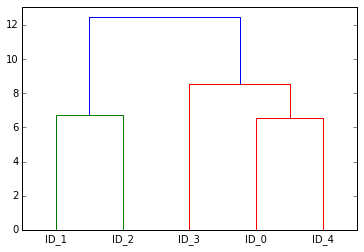

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters, labels=labels)

<br>
<br>

## Heatmaps

[[back to top](#Sections)]

This section is about the visualization of our hierarchical clustering. Here, we will plot simple heatmaps for each scenario: The original data, the data after row clustering, and eventually the data after we applied row and column clustering.

<br>
<br>

### Heatmap of the Original Data

[[back to top](#Sections)]

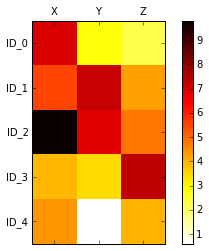

In [7]:
fig = plt.figure()

ax = fig.add_subplot(111)

cax = ax.matshow(df, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)

ax.set_xticklabels([''] + list(df.columns))
ax.set_yticklabels([''] + list(df.index))

plt.show()

<br>
<br>

### Heatmap after Row-Clustering

[[back to top](#Sections)]

The `dendrogram` function returns a dictionary with various items which are explained in detail in the scipy documenation [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html). The dendrogram leave order can then be accessed via the `'leaves'` key, e.g.,

In [8]:
row_dendr['leaves']

[1, 2, 3, 0, 4]

Thus, in order to sort the DataFrame according to the clustering, we can simply use the `'leaves'` as indices like so:  

    df.ix[row_dendr['leaves']]

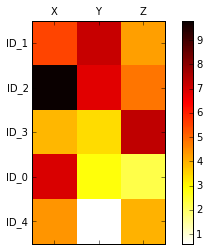

In [9]:
# reorder rows with respect to the clustering
row_dendr = dendrogram(row_clusters, labels=labels, no_plot=True)
df_rowclust = df.ix[row_dendr['leaves']]

# plot
fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)

ax.set_xticklabels([''] + list(df_rowclust.columns))
ax.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

<br>
<br>

### Heatmap plus Row-Dendrogram

[[back to top](#Sections)]

Now, we can rotate the dendrogram via the by setting the `orientation` parameter to `'right'`, but note that
we now have to sort the clustered data in reverse order to match the row labels in the heatmap via

    df.ix[row_dendr['leaves'][::-1]]

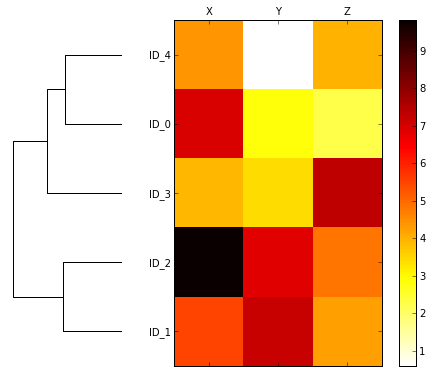

In [10]:
from scipy.cluster import hierarchy
# makes dendrogram black (1)
hierarchy.set_link_color_palette(['black'])

# plot row dendrogram
fig = plt.figure(figsize=(8,8))
axd = fig.add_axes([0.09,0.1,0.2,0.6])
row_dendr = dendrogram(row_clusters, orientation='right', 
                   color_threshold=np.inf, ) # makes dendrogram black (2))

# reorder data with respect to clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])


# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# reorder rows with respect to the clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]
        
# plot heatmap
axm = fig.add_axes([0.26,0.1,0.6,0.6]) # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

<br>
<br>

### Adding a Column Dendrogram

[[back to top](#Sections)]

Also, we can add a an additional dendrogram for the column clustering at the top. Here, we first sort the indexes after clustering the rows

    df_rowclust = df.ix[row_dendr['leaves'][::-1]]
    
And then we can use the indices from the column clustering to reorder the columns:

    df_rowclust.columns = [df_rowclust.columns[col_dendr['leaves']]]

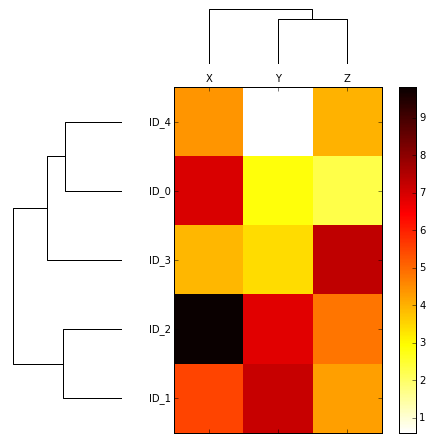

In [12]:
# Compute pairwise distances for columns
col_dists = squareform(pdist(df.T, metric='euclidean'))
col_clusters = linkage(col_dists, method='complete')

# plot column dendrogram
fig = plt.figure(figsize=(8,8))

axd2 = fig.add_axes([0.38,0.74,0.36,0.10]) 
col_dendr = dendrogram(col_clusters, orientation='top',
                       color_threshold=np.inf) # makes dendrogram black)
axd2.set_xticks([])
axd2.set_yticks([])

# plot row dendrogram
axd1 = fig.add_axes([0.09,0.1,0.2,0.6])
row_dendr = dendrogram(row_clusters, orientation='right',  
                       count_sort='ascending',
                       color_threshold=np.inf) # makes dendrogram black
axd1.set_xticks([])
axd1.set_yticks([])

# remove axes spines from dendrogram
for i,j in zip(axd1.spines.values(), axd2.spines.values()):
        i.set_visible(False)
        j.set_visible(False)
        

# reorder columns and rows with respect to the clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]
df_rowclust.columns = [df_rowclust.columns[col_dendr['leaves']]]

# plot heatmap
axm = fig.add_axes([0.26,0.1,0.6,0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

<br>
<br>

# Important Warning About Adding Dendrograms

[[back to top](#Sections)]

It is very important that you always check that the labels on the heatmap and the dendrogram match when you create the first plot! For example, we can provide the `labels` to the `labels` parameter of the dendrogram and **DON'T set `axd.set_yticks([])`** to show the labels on the dendrogram to compare them to the heatmap labels.

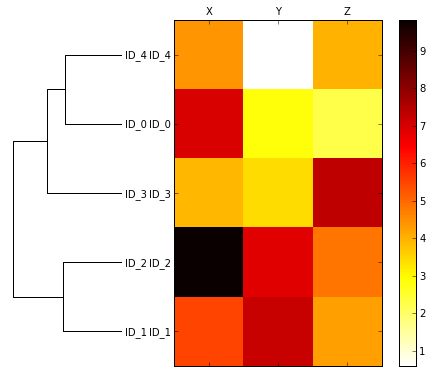

In [13]:
from scipy.cluster import hierarchy
# makes dendrogram black (1)
hierarchy.set_link_color_palette(['black'])

# plot row dendrogram
fig = plt.figure(figsize=(8,8))
axd = fig.add_axes([0.09,0.1,0.2,0.6])
row_dendr = dendrogram(row_clusters, orientation='right', 
                   labels=labels,
                   color_threshold=np.inf, ) # makes dendrogram black (2))
axd.set_xticks([])

# uncomment to hide dendrogram labels
#axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# reorder columns and rows with respect to the clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]
        
# plot heatmap
axm = fig.add_axes([0.26,0.1,0.6,0.6]) # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()